In [16]:
import time
from spade.agent import Agent
from spade.behaviour import CyclicBehaviour, PeriodicBehaviour, OneShotBehaviour, FSMBehaviour, State
from spade.message import Message
from spade.template import Template
import json
import asyncio
from random import random
from copy import deepcopy
import pandas as pd

import dash
import dash_bootstrap_components as dbc
import pandas as pd
import plotly.express as px
from dash import Input, Output, dcc, html

from datetime import datetime
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import numpy as np

In [17]:
password="Secret777"

In [18]:
jid ="SystemAgent@jabbim.pl"

In [19]:
class MachineAgent(Agent):

    def __init__(self, jid, password, verify_security, inputs, outputs, production_time, chance_to_break, magazine, item_prices, euro, up_price, down_price, providers, maintainers, stock):
        self.inputs=inputs
        self.outputs=outputs
        self.production_time=production_time
        self.chance_to_break=chance_to_break
        self.magazine=magazine
        self.item_prices=item_prices
        self.euro=euro
        self.up_price=up_price
        self.down_price=down_price
        self.providers=providers
        self.maintainers=maintainers
        self.stock=stock
        self.needed={item:self.inputs[item]-self.magazine[item] for item in self.inputs if self.magazine[item]<self.inputs[item]}
        self.start_production=True
        self.working_status=True
        
        super().__init__(jid, password, verify_security=verify_security)

    class ProduceBehav(CyclicBehaviour):
        async def run(self):
            await asyncio.sleep(0.1)
            self.agent.needed={item:self.agent.inputs[item]-self.agent.magazine[item] for item in self.agent.inputs if self.agent.magazine[item]<self.agent.inputs[item]}
            if(random()<self.agent.chance_to_break or self.agent.working_status==False):
                if self.agent.working_status:
                    print("broken")

                self.agent.working_status=False
                for maintainer in self.agent.maintainers:
                    msg = Message(to=maintainer)
                    msg.set_metadata("repair", "request")
                    await self.send(msg)
                    print("can you repair me?")
                    msg = await self.receive(timeout=10)
                    if msg:
                        if msg.get_metadata("repair")=="accepted":
                            print("waiting for repair")     
                            msg = await self.receive(timeout=10)
                            if msg:
                                if msg.get_metadata("repair")=="machine":
                                    self.agent.working_status=True
                                    print("Thank you for repair")
                                    break
                    else:
                        print("answer not received")

            if self.agent.start_production and self.agent.working_status and len(self.agent.needed)==0:
                await asyncio.sleep(self.agent.production_time)
                for item in self.agent.inputs:
                    self.agent.magazine[item]=self.agent.magazine[item]-self.agent.inputs[item]
                for item in self.agent.outputs:
                    self.agent.magazine[item]=self.agent.magazine[item]+self.agent.outputs[item]

                self.agent.stock.notify(str(self.agent.jid),datetime.today(),self.agent.magazine)

    class BuyBehav(CyclicBehaviour):

        async def run(self):
            await asyncio.sleep(0.1)
            if len(self.agent.needed)>0:
                for item in self.agent.needed:
                    propositions_list=[]
                    for Provider in self.agent.providers[item]:
                        msg = Message(to=Provider)
                        msg.set_metadata("buy", "order")
                        #msg.body = json.dumps({"item": item,"quantity":str(self.agent.needed[item])})
                        msg.body = json.dumps({"item": item,"quantity":1})
                        await self.send(msg)
                        print(Provider+" please "+item)
                        
                    
                    while len(propositions_list)<len(self.agent.providers[item]):
                        msg = await self.receive(timeout=10)
                        propositions_list.append(msg)
                    
                    best_price=100000
                    best_proposition=None
                    for msg in propositions_list:
                        if msg:
                            if msg.get_metadata("sell")=="proposition":
                                print("Message received with content: {}".format(msg.body))
                                body = json.loads(msg.body)
                                get_item = body["item"]
                                get_payment = int(body["payment"])
                                if get_payment<best_price:
                                    best_proposition=msg
                                    best_price=get_payment
                                
                    if best_proposition:
                        msg = Message(to=str(best_proposition.sender))
                        msg.set_metadata("buy", "payment")
                        if item in self.agent.needed.keys() and self.agent.euro>=best_price:
                            #msg.body = json.dumps({"item": item, "quantity":str(self.agent.needed[item]),"payment":str(best_price)})
                            msg.body = json.dumps({"item": item, "quantity":1,"payment":str(best_price)})
                            self.agent.euro-=best_price
                            await self.send(msg)
                            print("sending cash")
                            
                            msg = await self.receive(timeout=10)
                            if msg:
                                if msg.get_metadata("sell")=="product":
                                    body = json.loads(msg.body)
                                    get_item = body["item"]
                                    get_quantity = int(body["quantity"])
                                    self.agent.magazine[item]=self.agent.magazine[item]+get_quantity
                                    self.agent.stock.notify(str(self.agent.jid),datetime.today(),self.agent.magazine)
                                    print("thank you " + str(best_proposition.sender))
                                if msg.get_metadata("sell")=="refund":
                                    body = json.loads(msg.body)
                                    get_payment = int(body["payment"])
                                    self.agent.euro+=get_payment
                                    print("refund got " + str(best_proposition.sender))

            

    class SellBehav(CyclicBehaviour):
        async def run(self):
            msg = await self.receive(timeout=10)
            if msg:
                get_type=msg.get_metadata("buy")
                body = json.loads(msg.body)
                get_item = body["item"]
                get_quantity = int(body["quantity"])
                if get_type=="order":
                    if self.agent.magazine[get_item]>=get_quantity:
                        msg = Message(to=str(msg.sender))
                        msg.set_metadata("sell", "proposition")
                        #update price
                        print("Changing price from "+str(self.agent.item_prices[get_item])+" to "+str(int(self.agent.item_prices[get_item]*self.agent.down_price)))
                        self.agent.item_prices[get_item]=int(self.agent.item_prices[get_item]*self.agent.down_price)
                        msg.body = json.dumps({"item": get_item,"payment":str(self.agent.item_prices[get_item]*get_quantity)})
                        await self.send(msg)
                        print("proposing")
                    else:
                        msg = Message(to=str(msg.sender))
                        msg.set_metadata("sell", "decline")
                        msg.body = json.dumps({"item": get_item, "quantity":0})
                        await self.send(msg)
                        print("no item now")
                        self.agent.start_production=True
                        
                if get_type=="payment":
                    get_payment = int(body["payment"])                    
                    self.agent.euro+=get_payment
                    if self.agent.magazine[get_item]-get_quantity>=0:
                        self.agent.magazine[get_item]=self.agent.magazine[get_item]-get_quantity
                        self.agent.stock.notify(str(self.agent.jid),datetime.today(),self.agent.magazine)
                        msg = Message(to=str(msg.sender))
                        msg.set_metadata("sell", "product")
                        msg.body = json.dumps({"item": get_item,"quantity":str(get_quantity)})
                        #update price
                        print("up price")
                        self.agent.item_prices[get_item]=int(self.agent.item_prices[get_item]*self.agent.up_price)
                        await self.send(msg)
                        print("sending product")
                    else:
                        msg = Message(to=str(msg.sender))
                        msg.set_metadata("sell", "refund")
                        msg.body = json.dumps({"payment":str(get_payment)})
                        self.agent.euro-=get_payment
                        await self.send(msg)
                        print("sending refund")
                    
            else:
                print("waiting for sell")

    async def setup(self):
        print(f"MachineAgent started at {datetime.now().time()}")
        t_repair = Template()
        t_repair.set_metadata("repair", "machine")
        t_repair_decline = Template()
        t_repair_decline.set_metadata("repair", "declined")
        t_repair_accepted = Template()
        t_repair_accepted.set_metadata("repair", "accepted")
        t_product = Template()
        t_product.set_metadata("sell", "product")
        t_decline = Template()
        t_decline.set_metadata("sell", "decline")
        t_proposition = Template()
        t_proposition.set_metadata("sell", "proposition")
        t_refund = Template()
        t_refund.set_metadata("sell", "refund")
        t_order = Template()
        t_order.set_metadata("buy", "order")
        t_payment = Template()
        t_payment.set_metadata("buy", "payment")
        self.p = self.ProduceBehav()
        self.add_behaviour(self.p,t_repair | t_repair_decline | t_repair_accepted)
        self.b = self.BuyBehav()
        self.add_behaviour(self.b,t_product | t_decline | t_proposition | t_refund)
        self.s = self.SellBehav()
        self.add_behaviour(self.s,t_payment | t_order)
        self.stock.notify(str(self.jid),datetime.today(),self.magazine)
        await asyncio.sleep(4)

In [20]:
class OrderAgent(Agent):

    def __init__(self, jid: str, password: str, verify_security: bool, need, magazine, request_time, max_item_price, providers, stock):
        self.need=need
        self.providers=providers
        self.magazine=magazine
        self.request_time=request_time
        self.max_item_price=max_item_price
        self.stock=stock
        super().__init__(jid, password, verify_security=verify_security)

    class GetBehav(CyclicBehaviour):
        async def run(self):
            
            await asyncio.sleep(self.agent.request_time)
            item=self.agent.need
            propositions_list=[]
            for Provider in self.agent.providers[item]:
                msg = Message(to=Provider)
                msg.set_metadata("buy", "order")
                msg.body = json.dumps({"item": item,"quantity":1})
                await self.send(msg)
                print(Provider+" please "+item)


            while len(propositions_list)<len(self.agent.providers[item]):
                msg = await self.receive(timeout=10)
                propositions_list.append(msg)


            best_price=100000
            best_proposition=None
            for msg in propositions_list:
                if msg:
                    if msg.get_metadata("sell")=="proposition":
                        print("Message received with content: {}".format(msg.body))
                        body = json.loads(msg.body)
                        get_item = body["item"]
                        get_payment = int(body["payment"])
                        if get_payment<best_price and get_payment<=self.agent.max_item_price:
                            best_proposition=msg
                            best_price=get_payment

            if best_proposition:
                msg = Message(to=str(best_proposition.sender))
                msg.set_metadata("buy", "payment")
                msg.body = json.dumps({"item": item, "quantity":1,"payment":str(best_price)})
                await self.send(msg)
                print("sending cash "+str(best_price))
                msg = await self.receive(timeout=10)
                if msg:
                    if msg.get_metadata("sell")=="product":
                        body = json.loads(msg.body)
                        get_item = body["item"]
                        get_quantity = int(body["quantity"])
                        self.agent.magazine[item]=self.agent.magazine[item]+get_quantity
                        self.agent.stock.notify(str(self.agent.jid),datetime.today(),self.agent.magazine)
                        print("thank you " + str(best_proposition.sender))
                    if msg.get_metadata("sell")=="refund":
                        body = json.loads(msg.body)
                        get_payment = int(body["payment"])
                        print("refund got " + str(best_proposition.sender))


    async def setup(self):
        print(f"OrderAgent started at {datetime.now().time()}")
        t_product = Template()
        t_product.set_metadata("sell", "product")
        t_decline = Template()
        t_decline.set_metadata("sell", "decline")
        t_proposition = Template()
        t_proposition.set_metadata("sell", "proposition")
        t_refund = Template()
        t_refund.set_metadata("sell", "refund")
        self.b = self.GetBehav()
        self.add_behaviour(self.b,t_product | t_decline | t_proposition | t_refund)
        self.stock.notify(str(self.jid),datetime.today(),self.magazine)
        await asyncio.sleep(4)

In [21]:
class MaintenanceAgent(Agent):
    def __init__(self, jid: str, password: str, verify_security: bool, repair_time):
        self.repair_time=repair_time
        self.busy=False
        self.client=None
        super().__init__(jid, password, verify_security=verify_security)
    

    class RepairBehav(CyclicBehaviour):
        async def run(self):
            await asyncio.sleep(1)
            #print(self.agent.client)
            if self.agent.busy and self.agent.client!=None:
                await asyncio.sleep(self.agent.repair_time)
                msg = Message(to=self.agent.client)
                msg.set_metadata("repair", "machine")
                print("Repairing "+self.agent.client)
                await self.send(msg)
                self.agent.busy=False

    class ListenBehav(CyclicBehaviour):
        async def run(self):
            await asyncio.sleep(1)
            msg = await self.receive(timeout=10)
            if msg:
                if msg.get_metadata("repair") and self.agent.busy==False:
                    print("repair accepted")
                    self.agent.client=str(msg.sender)
                    msg = Message(to=str(msg.sender))
                    msg.set_metadata("repair", "accepted")
                    await self.send(msg)
                    self.agent.busy=True
                else:
                    msg = Message(to=str(msg.sender))
                    msg.set_metadata("repair", "declined")
                    await self.send(msg)

    async def setup(self):
        print(f"MaintenanceAgent started at {datetime.now().time()}")
        t_repair = Template()
        t_repair.set_metadata("repair", "request")
        self.l = self.ListenBehav()
        self.add_behaviour(self.l,t_repair)
        self.r = self.RepairBehav()
        self.add_behaviour(self.r)

In [28]:
class Stock():

    def __init__(self,agent_magazines):
        self.agent_magazines=agent_magazines

    def notify(self,agent,timestamp,magazine):
        self.agent_magazines[agent].append((timestamp,deepcopy(magazine)))
        
    def flatten(self):
        data=self.agent_magazines
        flat=[]
        for a in data:
            for r in data[a]:
                time=r[0]
                for p in r[1]:
                    flat.append({"time":time,"product":p,"quantity":r[1][p],"agent":a})

        df=pd.DataFrame(flat)
        return df
    
    def calculate_slope(self):
        df=self.flatten()

        df['secvalue']=df["time"].astype(np.int64)/1e+9

        df2=df.groupby(["agent","product"])

        df2=df2['quantity'].diff()/df2['secvalue'].diff()

        df3=pd.concat([df,df2], axis=1)

        df3=df3.dropna()

        df3=df3.rename(columns = {0:'slope'})

        df4=df3.set_index("time").groupby(["agent","product"]).rolling("10S").mean().reset_index()
        return df4

In [50]:
class Factory():
    def __init__(self,jid,password):
        self.jid=jid
        self.password=password
        self.max_id=0
        
    def load_agents(self,factory_setting):
        with open(factory_setting) as json_file:
            data = json.load(json_file)
        json_file.close()
        
        maintainer_list=[]
        for ma in data["Maintainers"]:
            for i in range(ma["number"]):
                self.max_id+=1
                maintainer_list.append(MaintenanceAgent(self.jid+"/"+str(self.max_id), self.password, False, ma["repair_time"]))
        
        machine_list=[]
        for m in data["Machines"]:
            for i in range(m["number"]):
                self.max_id+=1
                machine_list.append(MachineAgent(self.jid+"/"+str(self.max_id), self.password, False, m["inputs"],m["outputs"],m["production_time"],m["chance_to_break"],deepcopy(m["magazine"]),deepcopy(m["item_prices"]),m["euro"],m["up_price"],m["down_price"],None,maintainer_list,None))
        
        Providers={}
        
        for m in machine_list:
            for p in m.outputs:
                if p in Providers:
                    Providers[p].append(str(m.jid))
                else:
                    Providers[p]=[str(m.jid)]
                
        for m in machine_list:
            m.providers={p:Providers[p] for p in m.inputs if p in Providers}
        
        order_list=[]
        for o in data["Orders"]:
            for i in range(o["number"]):
                self.max_id+=1
                order_list.append(OrderAgent(self.jid+"/"+str(self.max_id), self.password, False, o["need"], deepcopy(o["magazine"]), o["request_time"],o["max_item_price"], None, None))

        for order in order_list:
            order.providers={p:Providers[p] for p in [order.need] if p in Providers}
            
        stock=Stock({str(m.jid):[] for m in machine_list+order_list})
        for m in machine_list+order_list:
            m.stock=stock
            
        self.Stock=stock
        self.Providers=Providers
        self.maintainer_list=maintainer_list
        self.machine_list=machine_list
        self.order_list=order_list
    
    def print_factory(self):
        G=nx.DiGraph()

        for o in self.order_list:
            G.add_node("O"+str(o.jid).split("/")[1])

        for m in self.machine_list:
            G.add_node("M"+str(m.jid).split("/")[1])

        for o in self.order_list:
            for p in o.providers:
                for m in o.providers[p]:
                    G.add_edge("M"+m.split("/")[1],"O"+str(o.jid).split("/")[1],product=p)

        for m in self.machine_list:
            for p in m.providers:
                if m.inputs[p]>0:
                    for m2 in m.providers[p]:
                        G.add_edge("M"+m2.split("/")[1],"M"+str(m.jid).split("/")[1],product=p)

        plt.figure(figsize=(8,8))

        pos = graphviz_layout(G, prog='dot')

        nx.draw(G,pos,with_labels=True)

        edge_labels = dict([((n1, n2), d['product'])
                            for n1, n2, d in G.edges(data=True)])

        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

        plt.show()
    
        return G
    
    def run_agents(self):
        
        app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])

        controls = dbc.Card(
            [
                html.Div(
                    [
                        dbc.Label("Product"),
                        dcc.Dropdown(
                            id="product",
                            options=[
                                {"label": col, "value": col} for col in self.Providers
                            ],
                            value=next(iter(self.Providers.keys())),
                        ),
                    ]
                ),
            ],
            body=True,
        )

        app.layout = dbc.Container(
            [
                dcc.Interval(id="refresh",interval=1*1000,n_intervals=0),
                html.H1("Factory 4.0"),
                html.Hr(),
                dbc.Row(
                    [
                        dbc.Col(controls, md=4),
                        dbc.Col(dcc.Graph(id="line-graph"), md=8),
                    ],
                    align="center",
                ),
            ],
            fluid=True,
        )


        @app.callback(
            Output("line-graph", "figure"),
            [
                Input("product", "value"),
                Input("refresh", "n_intervals"),
            ],
        )
        def make_graph(product,n):
            
            df=self.Stock.flatten()
            
            print(df.shape)

            df=df.loc[df["product"]==product]

            fig=px.line(df,x="time",y="quantity",color="agent")

            fig.layout["uirevision"]=True

            return fig
        
        
        try:
            for ma in self.maintainer_list:
                ma.start()
                
            for m in self.machine_list:
                m.start()
            
            for o in self.order_list:
                o.start()
            
            app.run_server(debug=False, port=8050)
        except Exception as e:
            print(e)
        finally:
            print("STOPPING!")
            for ag in self.maintainer_list+self.machine_list+self.order_list:
                ag.stop()          

In [51]:
factory=Factory(jid,password)

In [52]:
#factory.load_agents('experiments/exp14.json')

In [53]:
factory.load_agents('Factory1.json')

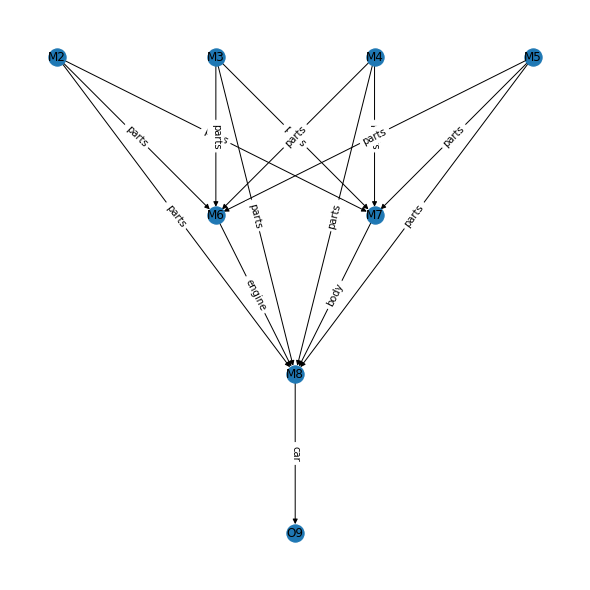

In [54]:
factory.print_factory()

In [33]:
factory.run_agents()
#app.run_server(debug=False, port=8050)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)


OrderAgent started at 09:11:23.609935
MachineAgent started at 09:11:23.610440
MachineAgent started at 09:11:23.611227
MachineAgent started at 09:11:23.611703
MachineAgent started at 09:11:23.707405
MachineAgent started at 09:11:23.749976
MachineAgent started at 09:11:23.758949
MaintenanceAgent started at 09:11:23.763056
MachineAgent started at 09:11:23.956045
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
systemagent@jabbim.pl/8 please car
no item now
systemagent@jabbim.pl/8 please car
no item now
systemagent@jabbim.pl/8 please car
no it

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 123 to 116
proposing
Changing price from 123 to 116
proposing
Changing price from 123 to 116
proposing
Changing price from 123 to 116
proposing
Message received with content: {"item": "parts", "payment": "116"}
Message received with content: {"item": "parts", "payment": "116"}
Message received with content: {"item": "parts", "payment": "116"}
Message received with content: {"item": "parts", "payment": "116"}
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 116 to 110
proposing
Changing price from 116 to 110
proposing
Changing price from 116 to 110
proposing
Changing price from 116 to 110
proposing
Message received with content: {"item": "parts", "payment": "110"}
Message received with content: {"item": "

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 49 to 46
proposing
Changing price from 49 to 46
proposing
Changing price from 49 to 46
proposing
Changing price from 49 to 46
proposing
Message received with content: {"item": "parts", "payment": "46"}
Message received with content: {"item": "parts", "payment": "46"}
Message received with content: {"item": "parts", "payment": "46"}
Message received with content: {"item": "parts", "payment": "46"}
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 46 to 43
proposing
Changing price from 46 to 43
proposing
Changing price from 46 to 43
proposing
Changing price from 46 to 43
proposing
Message received with content: {"item": "parts", "payment": "43"}
Message received with content: {"item": "parts", "payment": "4

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 17 to 16
proposing
Changing price from 17 to 16
proposing
Changing price from 17 to 16
proposing
Changing price from 17 to 16
proposing
Message received with content: {"item": "parts", "payment": "16"}
Message received with content: {"item": "parts", "payment": "16"}
Message received with content: {"item": "parts", "payment": "16"}
Message received with content: {"item": "parts", "payment": "16"}
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 16 to 15
proposing
Changing price from 16 to 15
proposing
Changing price from 16 to 15
proposing
Changing price from 16 to 15
proposing
Message received with content: {"item": "parts", "payment": "15"}
Message received with content: {"item": "parts", "payment": "1

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 1 to 0
proposing
Changing price from 1 to 0
proposing
Changing price from 1 to 0
proposing
Changing price from 1 to 0
proposing
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
thank you systemagent@jabbim.pl/2
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Message received with content: {"item": "parts", "payment": "0"}
Message rec

waiting for sell
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
thank you systemagent@jabbim.pl/2
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Message received with content: {"item": "parts", "payment":

systemagent@jabbim.pl/8 please car
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
thank you systemagent@jabbim.pl/2
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Message received with content: {"item": "parts", "paym

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
thank you systemagent@jabbim.pl/3
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
sending cash
thank you systemagent@jabbim.pl/4
up price
sending product
thank you systemagent@jabbim.pl/4
systemagent@jabbim.pl/6 please engine
Changing price from 361 to 342
proposing
Message received with con

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/6 please engine
no item now
no item now
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Changing price from 223 to 211
proposing
Message received with content: {"item": "engine", "payment": "211"}
systemagent@jabbim.pl/7 please body
no item now
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
thank you systemagent@jabbim.pl/4
systemagent@jabbim.pl/6 please engine
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 211 to 200
proposing
no item now
no item now
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Message received with content: {

systemagent@jabbim.pl/6 please engine
Changing price from 116 to 110
proposing
Message received with content: {"item": "engine", "payment": "110"}
systemagent@jabbim.pl/7 please body
Changing price from 248 to 235
proposing
Message received with content: {"item": "body", "payment": "235"}
systemagent@jabbim.pl/6 please engine
Changing price from 110 to 104
proposing
Message received with content: {"item": "engine", "payment": "104"}
systemagent@jabbim.pl/7 please body
Changing price from 235 to 223
proposing
Message received with content: {"item": "body", "payment": "223"}
systemagent@jabbim.pl/8 please car
no item now
systemagent@jabbim.pl/6 please engine
Changing price from 104 to 98
proposing
Message received with content: {"item": "engine", "payment": "98"}
systemagent@jabbim.pl/7 please body
Changing price from 223 to 211
proposing
Message received with content: {"item": "body", "payment": "211"}
systemagent@jabbim.pl/6 please engine
Changing price from 98 to 93
proposing
Message 

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/6 please engine
no item now
no item now
no item now
Changing price from 0 to 0
proposing
Changing price from 52 to 49
proposing
Message received with content: {"item": "engine", "payment": "49"}
systemagent@jabbim.pl/7 please body
Changing price from 116 to 110
proposing
Message received with content: {"item": "parts", "payment": "0"}
sending cash
Message received with content: {"item": "body", "payment": "110"}
up price
sending product
thank you systemagent@jabbim.pl/5
systemagent@jabbim.pl/6 please engine
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 49 to 46
proposing
no item now
no item now
no item now
Changing price from 0 to 0
proposing
Message received with content: {"item": "engine", "paymen

systemagent@jabbim.pl/6 please engine
Changing price from 18 to 17
proposing
Message received with content: {"item": "engine", "payment": "17"}
systemagent@jabbim.pl/7 please body
Changing price from 46 to 43
proposing
Message received with content: {"item": "body", "payment": "43"}
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
thank you systemagent@jabbim.pl/3
systemagent@jabbim.pl/6 please engine
Changing price from 17 to 16
proposing
Message received with content: {"item": "engine", "payment": "16"}
systemagent@jabbim.pl/7 please body
Changing price from 43 to 40
proposing
Message received with content: {"item": "body", "

systemagent@jabbim.pl/6 please engine
Changing price from 4 to 3
proposing
Message received with content: {"item": "engine", "payment": "3"}
systemagent@jabbim.pl/7 please body
Changing price from 18 to 17
proposing
Message received with content: {"item": "body", "payment": "17"}
systemagent@jabbim.pl/6 please engine
Changing price from 3 to 2
proposing
Message received with content: {"item": "engine", "payment": "2"}
systemagent@jabbim.pl/7 please body
Changing price from 17 to 16
proposing
Message received with content: {"item": "body", "payment": "16"}
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item

systemagent@jabbim.pl/7 please body
Changing price from 6 to 5
proposing
Message received with content: {"item": "body", "payment": "5"}
systemagent@jabbim.pl/7 please body
Changing price from 5 to 4
proposing
Message received with content: {"item": "body", "payment": "4"}
systemagent@jabbim.pl/7 please body
Changing price from 4 to 3
proposing
Message received with content: {"item": "body", "payment": "3"}
systemagent@jabbim.pl/7 please body
Changing price from 3 to 2
proposing
Message received with content: {"item": "body", "payment": "2"}
systemagent@jabbim.pl/7 please body
Changing price from 2 to 1
proposing
Message received with content: {"item": "body", "payment": "1"}
systemagent@jabbim.pl/7 please body
Changing price from 1 to 0
proposing
Message received with content: {"item": "body", "payment": "0"}
sending cash
up price
sending product
thank you systemagent@jabbim.pl/7
systemagent@jabbim.pl/8 please car
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please 

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
sending cash
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "paym

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
no item now
no item now
Changing price from 0 to 0
proposing
Changing price from 0 to 0
proposing
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
sending cash
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
sending refund
thank you systemagent@jabbim.pl/4
refund got systemagent@jabbim.pl/4
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
sy

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending produc

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please 

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
sending cash
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "paym

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
Changing price from 0 to 0
proposing
no item now
no item

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
syste

Message received with content: {"item": "parts", "payment": "0"}
sending cash
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
sending refund
thank you systemagent@jabbim.pl/5
refund got systemagent@jabbim.pl/5
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please 

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
syste

systemagent@jabbim.pl/8 please car
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please p

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 0 to 0
proposing
no item now
no item now
no item now
Changing price from 0 to 0
proposing
no item now
no item now
no item now
Message received with content: {"item": "parts", "payment": "0"}
sending cash
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
sending refund
thank you systemagent@jabbim.pl/2
refund got systemagent@jabbim.pl/2
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please par

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
Changing price from 0 to 0
proposing
no item now
no item now
no item now
Changing price from 0 to 0
proposing
Message received with content: {"item": "parts", "payment": "0"}
sending cash
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
sending refund
thank you systemagent@jabbim.pl/5
refund got systemagent@jabbim.pl/5
systemagent@jabbim.pl/8 please car
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
sending cash
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "paym

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
Changing price from 0 to 0
proposing
no item now
no item now
no item now
Changing price from 0 to 0
proposing
Message received with content: {"item": "parts", "payment": "0"}
sending cash
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
sending refund
thank you systemagent@jabbim.pl/5
refund got systemagent@jabbim.pl/5
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please par

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
Changing price from 0 to 0
proposing
no item now
no item now
no item now
Changing price from 0 to 0
proposing
no item now
no item now
Message received with content: {"item": "parts", "payment": "0"}
sending cash
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
sending refund
thank you systemagent@jabbim.pl/3
refund got systemagent@jabbim.pl/3
systemagent@jabbim.pl/8 please car
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
Changing price from 0 to 0
proposing
no item now
no item now
no item now
Changing price from 0 to 0
proposing
no item now
no item now
no item now
Changing price from 0 to 0
proposing
Message received with content: {"item": "parts", "payment": "0"}
sending cash
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
Message received with content: {"item": "parts", "payment": "0"}
sending cash
sending refund
thank you systemagent@jabbim.pl/5
sending refund
refund got sys

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
Changing price from 0 to 0
proposing
no item now
no item now
no item now
Changing price from 0 to 0
proposing
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
Changing price from 0 to 0
proposing
no item now
no item now
Message received with content: {"item": "parts", "payment": "0"}
sending cash
Message received with content: {"item": "parts", "payment": "0"

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Changing price from 0 to 0
proposing
no item now
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
sending cash
Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
sending refund
thank you systemagent@jabbim.pl/2
refund got systemagent@jabbim.pl/2
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
sy

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please 

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
Changing price from 0 to 0
proposing
no item now
no item now
no item now
Changing price from 0 to 0
proposing
Message received with content: {"item": "parts", "payment": "0"}
sending cash
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
sending refund
thank you systemagent@jabbim.pl/5
refund got systemagent@jabbim.pl/5
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
syste

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/6 please engine
Changing price from 0 to 0
proposing
Message received with content: {"item": "engine", "payment": "0"}
sending cash
up price
sending product
thank you systemagent@jabbim.pl/6
systemagent@jabbim.pl/7 please body
Changing price from 0 to 0
proposing
Message received with content: {"item": "body", "payment": "0"}
sending cash
up price
sending product
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
thank you systemagent@jabbim.pl/7
no item now
no item now
no item now
Changing price from 0 to 0
proposing
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
thank you systemagent@jabbim.pl/5
systemagent@jabbim.pl/2 

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
syste

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 0 to 0
proposing
no item now
no item now
no item now
Changing price from 0 to 0
proposing
no item now
no item now
no item now
Changing price from 0 to 0
proposing
no item now
no item now
no item now
Message received with content: {"item": "parts", "payment": "0"}
sending cash
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
Message received with content: {"item": "parts", "payment": "0"}
sending cash
sending refund
thank you systemagent@jabbim.pl/2
sending refund
refund got sys

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 0 to 0
proposing
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
Changing price from 0 to 0
proposing
no item now
no item now
no item now
Changing price from 0 to 0
proposing
no item now
no item now
no item now
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
Message received with content: {"item": "parts", "payment": "0"}
sending cash
thank you systemagent@jabbim.pl/2
Message received with content: {"item": "parts", "payment": "0"}
sending cash
sending refund
sending refund
refund got sys

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/8 please car
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please p

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
Changing price from 0 to 0
proposing
no item now
no item now
no item now
Changing price from 0 to 0
proposing
no item now
no item now
Message received with content: {"item": "parts", "payment": "0"}
sending cash
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
s

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/8 please car
Changing price from 588 to 558
proposing
Message received with content: {"item": "car", "payment": "558"}
sending cash 558
up price
sending product
thank you systemagent@jabbim.pl/8
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
Changing price from 0 to 0
proposing
no item now
no item no

Message received with content: {"item": "parts", "payment": "0"}
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
thank you systemagent@jabbim.pl/2
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
Changing price from 0 to 0
proposing
no item now
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
thank you systemagent@jabbim.pl/4
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
no item now
systemagent@jabbim.p

systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
systemagent@jabbim.pl/2 please parts
systemagent@jabbim.pl/3 please parts
systemagent@jabbim.pl/4 please parts
systemagent@jabbim.pl/5 please parts
no item now
no item now
no item now
Changing price from 0 to 0
proposing
no item now
no item now
no item now
Changing price from 0 to 0
proposing
no item now
no item now
no item now
Changing price from 0 to 0
proposing
Message received with content: {"item": "parts", "payment": "0"}
sending cash
Message received with content: {"item": "parts", "payment": "0"}
sending cash
up price
sending product
Message received with content: {"item": "parts", "payment": "0"}
sending cash
sending refund
thank you systemagent@jabbim.pl/5
sending refund
refund got sys

KeyboardInterrupt: 

no item now


In [35]:
df=factory.Stock.calculate_slope()

In [38]:
px.line(df.loc[df["product"]=="car"],x="time",y="quantity",color="agent")